# T81-558: Applications of Deep Neural Networks
**Module 3: Introduction to TensorFlow.**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module Video Material

Main video lecture:

* [Part 3.1: Neural Network Introduction](https://www.youtube.com/watch?v=W50SiRuu-cs&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 3.2: Introduction to Keras and Tensorflow](https://www.youtube.com/watch?v=PpH4KAEyhIM&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 3.3: Saving and Loading a Keras Neural Network](https://www.youtube.com/watch?v=dBpUg6JMQpk&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)

Weekly video update:

* *Will be posted week of this class*

# Helpful Functions

You will see these at the top of every module.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

## Neural Network Basics

Neural networks were one of the first machine learning models.  Their popularity has fallen twice and is now on its third rise.  Deep learning implies the use of neural networks.  The "deep" in deep learning refers to a neural network with many hidden layers.  Because neural networks have been around for so long, they have quite a bit of baggage.  Many different training algorithms, activation/transfer functions, and structures have been added over the years.  This course is only concerned with the latest, most current state of the art techniques for deep neural networks.  I am not going to spend any time discussing the history of neural networks.  If you would like to learn about some of the more classic structures of neural networks, there are several chapters dedicated to this in your course book.  For the latest technology, I wrote an article for the Society of Actuaries on deep learning as the [third generation of neural networks](https://www.soa.org/Library/Newsletters/Predictive-Analytics-and-Futurism/2015/december/paf-iss12.pdf).

Neural networks accept input and produce output.  The input to a neural network is called the feature vector.  The size of this vector is always a fixed length.  Changing the size of the feature vector means recreating the entire neural network.  Though the feature vector is called a "vector," this is not always the case.  A vector implies a 1D array.  Historically the input to a neural network was always 1D.  However, with modern neural networks you might see inputs, such as:

* **1D Vector** - Classic input to a neural network, similar to rows in a spreadsheet.  Common in predictive modeling.
* **2D Matrix** - Grayscale image input to a convolutional neural network (CNN).
* **3D Matrix** - Color image input to a convolutional neural network (CNN).
* **nD Matrix** - Higher order input to a CNN.

Prior to CNN's, the image input was sent to a neural network simply by squashing the image matrix into a long array by placing the image's rows side-by-side.  CNNs are different, as the nD matrix literally passes through the neural network layers.

Initially this course will focus upon 1D input to neural networks.  However, later sessions will focus more heavily upon higher dimension input.

**Dimensions** The term dimension can be confusing in neural networks.  In the sense of a 1D input vector, dimension refers to how many elements are in that 1D array.  For example a neural network with 10 input neurons has 10 dimensions.  However, now that we have CNN's, the input has dimensions too.  The input to the neural network will *usually* have 1, 2 or 3 dimensions.  4 or more dimensions is unusual.  You might have a 2D input to a neural network that has 64x64 pixels.  This would result in 4,096 input neurons.  This network is either 2D or 4,096D, depending on which set of dimensions you are talking about!

# Classification or Regression

Like many models, neural networks can function in classification or regression:

* **Regression** - You expect a number as your neural network's prediction.
* **Classification** - You expect a class/category as your neural network's prediction.

The following shows a classification and regression neural network:

![Neural Network Classification and Regression](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_ann_class_reg.png "Neural Network Classification and Regression")

Notice that the output of the regression neural network is numeric and the output of the classification is a class.  Regression, or two-class classification, networks always have a single output.  Classification neural networks have an output neuron for each class. 

The following diagram shows a typical neural network:

![Feedforward Neural Networks](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_ann.png "Feedforward Neural Networks")

There are usually four types of neurons in a neural network:

* **Input Neurons** - Each input neuron is mapped to one element in the feature vector.
* **Hidden Neurons** - Hidden neurons allow the neural network to abstract and process the input into the output.
* **Output Neurons** - Each output neuron calculates one part of the output.
* **Context Neurons** - Holds state between calls to the neural network to predict.
* **Bias Neurons** - Work similar to the y-intercept of a linear equation.  

These neurons are grouped into layers:

* **Input Layer** - The input layer accepts feature vectors from the dataset.  Input layers usually have a bias neuron.
* **Output Layer** - The output from the neural network.  The output layer does not have a bias neuron.
* **Hidden Layers** - Layers that occur between the input and output layers.  Each hidden layer will usually have a bias neuron.



# Neuron Calculation

The output from a single neuron is calculated according to the following formula:

$ f(x,\theta) = \phi(\sum_i(\theta_i \cdot x_i)) $

The input vector ($x$) represents the feature vector and the vector $\theta$ (theta) represents the weights. To account for the bias neuron, a value of 1 is always appended to the end of the input feature vector.  This causes the last weight to be interpreted as a bias value that is simply added to the summation. The $\phi$ (phi) is the transfer/activation function. 

Consider using the above equation to calculate the output from the following neuron:

![Single Neuron](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_abstract_nn.png "Single Neuron")

The above neuron has 2 inputs plus the bias as a third.  This neuron might accept the following input feature vector:

```
[1,2]
```

To account for the bias neuron, a 1 is appended, as follows:

```
[1,2,1]
```

The weights for a 3-input layer (2 real inputs + bias) will always have an additional weight, for the bias.  A weight vector might be:

```
[ 0.1, 0.2, 0.3]
```

To calculate the summation, perform the following:

```
0.1*1 + 0.2*2 + 0.3*3 = 1.4
```

The value of 1.4 is passed to the $\phi$ (phi) function, which represents the activation function.



# Activation Functions

Activation functions, also known as transfer functions, are used to calculate the output of each layer of a neural network.  Historically neural networks have used a hyperbolic tangent, sigmoid/logistic, or linear activation function.  However, modern deep neural networks primarily make use of the following activation functions:

* **Rectified Linear Unit (ReLU)** - Used for the output of hidden layers.
* **Softmax** - Used for the output of classification neural networks. [Softmax Example](http://www.heatonresearch.com/aifh/vol3/softmax.html)
* **Linear** - Used for the output of regression neural networks (or 2-class classification).

The ReLU function is calculated as follows:

$ \phi(x) = \max(0, x) $

The Softmax is calculated as follows:

$ \phi_i(z) = \frac{e^{z_i}}{\sum\limits_{j \in group}e^{z_j}} $

The Softmax activation function is only useful with more than one output neuron.  It ensures that all of the output neurons sum to 1.0.  This makes it very useful for classification where it shows the probability of each of the classes as being the correct choice.

To experiment with the Softmax, click [here](http://www.heatonresearch.com/aifh/vol3/softmax.html).

The linear activation function is essentially no activation function:

$ \phi(x) = x $

For regression problems, this is the activation function of choice.  



# Why ReLU?

Why is the ReLU activation function so popular?  It was one of the key improvements to neural networks that makes deep learning work. Prior to deep learning, the sigmoid activation function was very common:

$ \phi(x) = \frac{1}{1 + e^{-x}} $

The graph of the sigmoid function is shown here:

![Sigmoid Activation Function](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_sigmoid.png "Sigmoid Activation Function")

Neural networks are often trained using gradient descent.  To make use of gradient descent, it is necessary to take the derivative of the activation function.  This allows the partial derivatives of each of the weights to be calculated with respect to the error function.  A derivative is the instantaneous rate of change:

![Derivative](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_deriv.png "Derivative")

The derivative of the sigmoid function is given here:

$ \phi'(x)=\phi(x)(1-\phi(x)) $

This derivative is often given in other forms.  The above form is used for computational efficiency. To see how this derivative was taken, see [this](http://www.heatonresearch.com/aifh/vol3/deriv_sigmoid.html).

The graph of the sigmoid derivative is given here:

![Sigmoid Derivative](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_deriv_sigmoid.png "Sigmoid Derivative")

The derivative quickly saturates to zero as *x* moves from zero.  This is not a problem for the derivative of the ReLU, which is given here:

$ \phi'(x) = \begin{cases} 1 & x > 0 \\ 0 & x \leq 0 \end{cases} $

# Why are Bias Neurons Needed?

The activation functions seen in the previous section specifies the output of a single neuron.  Together, the weight and bias of a neuron shape the output of the activation to produce the desired output.  To see how this process occurs, consider the following equation. It represents a single-input sigmoid activation neural network.

$ f(x,w,b) = \frac{1}{1 + e^{-(wx+b)}} $ 

The *x* variable represents the single input to the neural network.  The *w* and *b* variables specify the weight and bias of the neural network.  The above equation is a combination of the weighted sum of the inputs and the sigmoid activation function.  For this section, we will consider the sigmoid function because it clearly demonstrates the effect that a bias neuron has.

The weights of the neuron allow you to adjust the slope or shape of the activation function.  The following figure shows the effect on the output of the sigmoid activation function if the weight is varied:

![Adjusting Weight](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_bias_weight.png "Bias 1")

The above diagram shows several sigmoid curves using the following parameters:

```
f(x,0.5,0.0)
f(x,1.0,0.0)
f(x,1.5,0.0)
f(x,2.0,0.0)
```

To produce the curves, we did not use bias, which is evident in the third parameter of 0 in each case. Using four weight values yields four different sigmoid curves in the above figure. No matter the weight, we always get the same value of 0.5 when x is 0 because all of the curves hit the same point when x is 0.  We might need the neural network to produce other values when the input is near 0.5.  

Bias does shift the sigmoid curve, which allows values other than 0.5 when x is near 0. The following figure shows the effect of using a weight of 1.0 with several different biases:


![Adjusting Bias](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_bias_value.png "Bias 1")

The above diagram shows several sigmoid curves with the following parameters:

```
f(x,1.0,1.0)
f(x,1.0,0.5)
f(x,1.0,1.5)
f(x,1.0,2.0)
```

We used a weight of 1.0 for these curves in all cases.  When we utilized several different biases, sigmoid curves shifted to the left or right.  Because all the curves merge together at the top right or bottom left, it is not a complete shift.

When we put bias and weights together, they produced a curve that created the necessary output from a neuron.  The above curves are the output from only one neuron.  In a complete network, the output from many different neurons will combine to produce complex output patterns.

# TensorFlow - Google

![TensorFlow](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_tensorflow.png "TensorFlow")

TensorFlow is an open source software library for machine learning in various kinds of perceptual and language understanding tasks. It is currently used for both research and production by different teams in many commercial Google products, such as speech recognition, Gmail, Google Photos, and search, many of which had previously used its predecessor DistBelief. TensorFlow was originally developed by the Google Brain team for Google's research and production purposes and later released under the Apache 2.0 open source license on November 9, 2015.

* [TensorFlow Homepage](https://www.tensorflow.org/)
* [TensorFlow GitHib](https://github.com/tensorflow/tensorflow)
* [TensorFlow Google Groups Support](https://groups.google.com/forum/#!forum/tensorflow)
* [TensorFlow Google Groups Developer Discussion](https://groups.google.com/a/tensorflow.org/forum/#!forum/discuss)
* [TensorFlow FAQ](https://www.tensorflow.org/resources/faq)


# What version of TensorFlow do you have?

TensorFlow is very new and changing rapidly.  It is very important that you run the same version of it that I am using.  For this semester we will use a specific version of TensorFlow (mentioned in the last class notes).

![Self Driving Car](http://imgc-cn.artprintimages.com/images/P-473-488-90/94/9475/CFB6500Z/posters/paul-noth-does-your-car-have-any-idea-why-my-car-pulled-it-over-new-yorker-cartoon.jpg)

[Wrong version of TensorFlow?](https://twitter.com/reza_zadeh/status/849160032608440320)

In [1]:
import tensorflow as tf
print("Tensor Flow Version: {}".format(tf.__version__))

/Users/jwalker/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Tensor Flow Version: 1.4.1


# Installing TensorFlow

* [IBM Data Scientist Workbench](datascientistworkbench.com) - All platforms, use your browser.
* Windows - Supported platform.
* Mac - Supported platform.
* Linux - Supported platform.

[TensorFlow Setup Instructions](https://www.tensorflow.org/versions/r0.10/get_started/os_setup.html#docker-based_installation)

# Why TensorFlow

* Supported by Google
* Works well on Linux/Mac
* Excellent GPU support
* Python is an easy to learn programming language
* Python is [extremely popular](http://www.kdnuggets.com/2014/08/four-main-languages-analytics-data-mining-data-science.html) in the data science community

# Other Deep Learning Tools
TensorFlow is not the only only game in town.  These are some of the best supported alternatives.  Most of these are written in C++. In order of my own preference (ordered in my own estimation of approximate importance):

* [TensorFlow](https://www.tensorflow.org/) Google's deep learning API.  The focus of this class, along with Keras.
* [MXNet](https://mxnet.incubator.apache.org/) Apache foundation's deep learning API. Can be used through Keras.
* [Theano](http://deeplearning.net/software/theano/) - Python, from the academics that created deep learning.
* [Keras](https://keras.io/) - Also by Google, higher level framework that allows the use of TensorFlow, MXNet and Theano interchangeably.
[Torch](http://torch.ch/) is used by Google DeepMind, the Facebook AI Research Group, IBM, Yandex and the Idiap Research Institute.  It has been used for some of the most advanced deep learning projects in the world.  However, it requires the [LUA](https://en.wikipedia.org/wiki/Lua_(programming_language)) programming language.  It is very advanced, but it is not mainstream.  I have not worked with Torch (yet!).
* [PaddlePaddle](https://github.com/baidu/Paddle) - [Baidu](http://www.baidu.com/)'s deep learning API.
* [Deeplearning4J](http://deeplearning4j.org/) - Java based. Supports all major platforms. GPU support in Java!
* [Computational Network Toolkit (CNTK)](https://github.com/Microsoft/CNTK) - Microsoft.  Support for Windows/Linux, command line only.  Bindings for predictions for C#/Python. GPU support.
* [H2O](http://www.h2o.ai/) - Java based.  Supports all major platforms.  Limited support for computer vision. No GPU support.



# Using TensorFlow

TensorFlow is a low-level mathematics API, similar to [Numpy](http://www.numpy.org/).  However, unlike Numpy, TensorFlow is built for deep learning.  TensorFlow works by allowing you to define compute graphs with Python.  In this regard, it is similar to [Spark](http://spark.apache.org/).  TensorFlow compiles these compute graphs into highly efficient C++/[CUDA](https://en.wikipedia.org/wiki/CUDA) code.

The [TensorBoard](https://www.tensorflow.org/versions/r0.10/how_tos/summaries_and_tensorboard/index.html) command line utility can be used to view these graphs.  The iris neural network's graph used in this class is shown here:

![Iris Graph](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_graph_tf.png "Iris Graph")

Expanding the DNN gives:


![Iris DNN Graph](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_graph_dnn.png "Iris DNN Graph")


# TensorFlow Graphs

So far we've communicated with TensorFlow using TensorFlow Learn, which allows you to specify the number of hidden layers and simply create the neural network.  

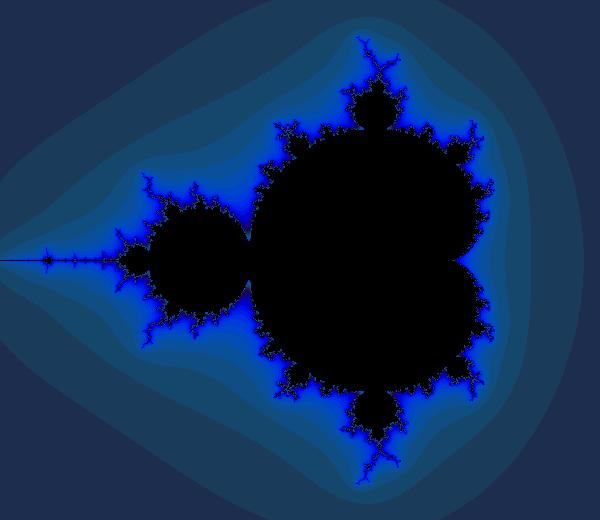

In [4]:
# Import libraries for simulation
import tensorflow as tf
import numpy as np

# Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import Image, display

def DisplayFractal(a, fmt='jpeg'):
  """Display an array of iteration counts as a
     colorful picture of a fractal."""
  a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
  img = np.concatenate([10+20*np.cos(a_cyclic),
                        30+50*np.sin(a_cyclic),
                        155-80*np.cos(a_cyclic)], 2)
  img[a==a.max()] = 0
  a = img
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  display(Image(data=f.getvalue()))

sess = tf.InteractiveSession()

# Use NumPy to create a 2D array of complex numbers

Y, X = np.mgrid[-1.3:1.3:0.005, -2:1:0.005]
Z = X+1j*Y

xs = tf.constant(Z.astype(np.complex64))
zs = tf.Variable(xs)
ns = tf.Variable(tf.zeros_like(xs, tf.float32))

tf.global_variables_initializer().run()

# Compute the new values of z: z^2 + x
zs_ = zs*zs + xs

# Have we diverged with this new value?
not_diverged = tf.abs(zs_) < 4

# Operation to update the zs and the iteration count.
#
# Note: We keep computing zs after they diverge! This
#       is very wasteful! There are better, if a little
#       less simple, ways to do this.
#
step = tf.group(
  zs.assign(zs_),
  ns.assign_add(tf.cast(not_diverged, tf.float32))
  )

for i in range(30): step.run()
    
DisplayFractal(ns.eval())

In [5]:
import tensorflow as tf

# Create a Constant op that produces a 1x2 matrix.  The op is
# added as a node to the default graph.
#
# The value returned by the constructor represents the output
# of the Constant op.
matrix1 = tf.constant([[3., 3.]])

# Create another Constant that produces a 2x1 matrix.
matrix2 = tf.constant([[2.],[2.]])

# Create a Matmul op that takes 'matrix1' and 'matrix2' as inputs.
# The returned value, 'product', represents the result of the matrix
# multiplication.
product = tf.matmul(matrix1, matrix2)

with tf.Session() as sess:
  result = sess.run([product])
  print(result)

[array([[ 12.]], dtype=float32)]


In [6]:
# Enter an interactive TensorFlow Session.
import tensorflow as tf
sess = tf.InteractiveSession()

x = tf.Variable([1.0, 2.0])
a = tf.constant([3.0, 3.0])

# Initialize 'x' using the run() method of its initializer op.
x.initializer.run()

# Add an op to subtract 'a' from 'x'.  Run it and print the result
sub = tf.subtract(x, a)
print(sub.eval())
# ==> [-2. -1.]

[-2. -1.]


In [7]:
sess.run(x.assign([4.0, 6.0]))

array([ 4.,  6.], dtype=float32)

In [8]:
print(sub.eval())

[ 1.  3.]


In [9]:
# Close the Session when we're done.
sess.close()

# Using Keras

[Keras](https://keras.io/) is a layer on top of Tensorflow that makes it much easier to create neural networks.  Rather than define the graphs, like you see above, you define the individual layers of the network with a much more high level API.  Unless you are performing research into entirely new structures of deep neural networks it is unlikely that you need to program TensorFlow directly.  

**For this class, we will use usually use TensorFlow through Keras, rather than direct TensorFlow**

Keras is a separate install from TensorFlow.  To install Keras, use **pip install keras** after **pip install tensorflow**.

# Helpful Functions for Tensorflow

The following functions will be used in conjunction with TensorFlow to help preprocess the data.  It is okay to just use them. For better understanding, try to understand how they work.

These functions allow you to build the feature vector for a neural network. Consider the following:

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.


In [10]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Simple TensorFlow Regression: MPG

This example shows how to encode the MPG dataset for regression.  This is slightly more complex than Iris, because:

* Input has both numeric and categorical
* Input has missing values

To encode categorical values that are part of the feature vector, use the functions from above.  If the categorical value is the target (as was the case with Iris, use the same technique as Iris). The iris technique allows you to decode back to Iris text strings from the predictions.

In [15]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

cars = df['name']
df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
x,y = to_xy(df,"mpg")
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=2,epochs=100)

Epoch 1/100
 - 0s - loss: 4701.0771
Epoch 2/100
 - 0s - loss: 1410.0536
Epoch 3/100
 - 0s - loss: 931.8542
Epoch 4/100
 - 0s - loss: 459.5984
Epoch 5/100
 - 0s - loss: 387.8222
Epoch 6/100
 - 0s - loss: 348.7399
Epoch 7/100
 - 0s - loss: 334.6148
Epoch 8/100
 - 0s - loss: 315.3447
Epoch 9/100
 - 0s - loss: 299.1659
Epoch 10/100
 - 0s - loss: 279.2672
Epoch 11/100
 - 0s - loss: 262.1453
Epoch 12/100
 - 0s - loss: 246.0135
Epoch 13/100
 - 0s - loss: 230.4846
Epoch 14/100
 - 0s - loss: 221.9480
Epoch 15/100
 - 0s - loss: 224.7045
Epoch 16/100
 - 0s - loss: 191.2137
Epoch 17/100
 - 0s - loss: 179.6388
Epoch 18/100
 - 0s - loss: 163.9042
Epoch 19/100
 - 0s - loss: 152.7982
Epoch 20/100
 - 0s - loss: 144.9909
Epoch 21/100
 - 0s - loss: 130.3446
Epoch 22/100
 - 0s - loss: 123.2760
Epoch 23/100
 - 0s - loss: 115.3391
Epoch 24/100
 - 0s - loss: 109.0943
Epoch 25/100
 - 0s - loss: 98.0323
Epoch 26/100
 - 0s - loss: 91.8660
Epoch 27/100
 - 0s - loss: 91.9751
Epoch 28/100
 - 0s - loss: 79.3145
Epo

## Controling the Amount of Output

One line is produced for each training epoch.  You can eliminate this output by setting the verbose setting of the fit command:

* **verbose=0** - No progress output (use with Juputer if you do not want output)
* **verbose=1** - Display progress bar, does not work well with Jupyter
* **verbose=2** - Summary progress output (use with Jupyter if you want to know the loss at each epoch)

## Regression Prediction

Next we will perform actual predictions.  These predictions are assigned to the **pred** variable. These are all MPG predictions from the neural network.  Notice that this is a 2D array?  You can always see the dimensions of what is returned by printing out **pred.shape**.  Neural networks can return multiple values, so the result is always an array.  Here the neural network only returns 1 value per prediction (there are 398 cars, so 398 predictions).  However, a 2D array is needed because the neural network has the potential of returning more than one value.   

In [16]:
pred = model.predict(x)
print("Shape: {}".format(pred.shape))
print(pred)

Shape: (398, 1)
[[ 14.59205437]
 [ 13.85222816]
 [ 15.20558357]
 [ 15.69162941]
 [ 14.88890648]
 [  9.54255867]
 [  9.54585457]
 [  9.68910027]
 [  9.54519081]
 [ 12.33182335]
 [ 13.92140007]
 [ 13.35810661]
 [ 11.73472404]
 [ 17.53576851]
 [ 24.62880135]
 [ 20.19042778]
 [ 20.5924511 ]
 [ 21.45267296]
 [ 25.92920876]
 [ 27.81345367]
 [ 23.11014938]
 [ 23.85677147]
 [ 25.21814919]
 [ 25.01073265]
 [ 20.9831295 ]
 [ 10.49651146]
 [ 12.44473839]
 [ 12.16018867]
 [ 11.11136436]
 [ 26.39363289]
 [ 24.9313736 ]
 [ 25.67463112]
 [ 27.88690758]
 [ 20.84433174]
 [ 16.98906136]
 [ 17.14694786]
 [ 16.92700005]
 [ 17.63622475]
 [ 11.37629128]
 [  9.35357857]
 [ 11.72670174]
 [ 12.28711128]
 [  6.81324625]
 [  7.65091944]
 [  5.45841074]
 [ 18.99008369]
 [ 24.47305679]
 [ 17.28844643]
 [ 17.62181664]
 [ 24.89478111]
 [ 25.89195633]
 [ 27.5804882 ]
 [ 26.31302834]
 [ 29.39752769]
 [ 30.18789864]
 [ 28.31159019]
 [ 28.19567108]
 [ 26.25754356]
 [ 26.89628601]
 [ 27.32953072]
 [ 25.64796448]
 [ 26.01

We would like to see how good these predictions are.  We know what the correct MPG is for each car, so we can measure how close the neural network was.

In [17]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 3.6859538555145264


This means that, on average the predictions were within +/- 5.89 values of the correct value.  This is not very good, but we will soon see how to improve it.

We can also print out the first 10 cars, with predictions and actual MPG.

In [18]:
# Sample predictions
for i in range(10):
    print("{}. Car name: {}, MPG: {}, predicted MPG: {}".format(i+1,cars[i],y[i],pred[i]))

1. Car name: chevrolet chevelle malibu, MPG: [ 18.], predicted MPG: [ 14.59205437]
2. Car name: buick skylark 320, MPG: [ 15.], predicted MPG: [ 13.85222816]
3. Car name: plymouth satellite, MPG: [ 18.], predicted MPG: [ 15.20558357]
4. Car name: amc rebel sst, MPG: [ 16.], predicted MPG: [ 15.69162941]
5. Car name: ford torino, MPG: [ 17.], predicted MPG: [ 14.88890648]
6. Car name: ford galaxie 500, MPG: [ 15.], predicted MPG: [ 9.54255867]
7. Car name: chevrolet impala, MPG: [ 14.], predicted MPG: [ 9.54585457]
8. Car name: plymouth fury iii, MPG: [ 14.], predicted MPG: [ 9.68910027]
9. Car name: pontiac catalina, MPG: [ 14.], predicted MPG: [ 9.54519081]
10. Car name: amc ambassador dpl, MPG: [ 15.], predicted MPG: [ 12.33182335]


# Simple TensorFlow Classification: Iris

This is a very simple example of how to perform the Iris classification using TensorFlow.  The iris.csv file is used, rather than using the built-in files that many of the Google examples require.  

**Make sure that you always run previous code blocks.  If you run the code block below, without the codeblock above, you will get errors**

In [19]:
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

url="https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/data/iris.csv"
df=pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')),na_values=['NA','?'])

species = encode_text_index(df,"species")
x,y = to_xy(df,"species")

# Split into train/test
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(y.shape[1],activation='softmax')) # Output

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(x,y,verbose=2,epochs=100)

Epoch 1/100
 - 0s - loss: 1.3347
Epoch 2/100
 - 0s - loss: 1.0599
Epoch 3/100
 - 0s - loss: 0.9293
Epoch 4/100
 - 0s - loss: 0.8600
Epoch 5/100
 - 0s - loss: 0.8032
Epoch 6/100
 - 0s - loss: 0.7460
Epoch 7/100
 - 0s - loss: 0.6987
Epoch 8/100
 - 0s - loss: 0.6594
Epoch 9/100
 - 0s - loss: 0.6221
Epoch 10/100
 - 0s - loss: 0.5885
Epoch 11/100
 - 0s - loss: 0.5604
Epoch 12/100
 - 0s - loss: 0.5336
Epoch 13/100
 - 0s - loss: 0.5105
Epoch 14/100
 - 0s - loss: 0.4882
Epoch 15/100
 - 0s - loss: 0.4678
Epoch 16/100
 - 0s - loss: 0.4497
Epoch 17/100
 - 0s - loss: 0.4306
Epoch 18/100
 - 0s - loss: 0.4153
Epoch 19/100
 - 0s - loss: 0.4030
Epoch 20/100
 - 0s - loss: 0.3872
Epoch 21/100
 - 0s - loss: 0.3798
Epoch 22/100
 - 0s - loss: 0.3647
Epoch 23/100
 - 0s - loss: 0.3543
Epoch 24/100
 - 0s - loss: 0.3458
Epoch 25/100
 - 0s - loss: 0.3326
Epoch 26/100
 - 0s - loss: 0.3245
Epoch 27/100
 - 0s - loss: 0.3151
Epoch 28/100
 - 0s - loss: 0.3086
Epoch 29/100
 - 0s - loss: 0.2973
Epoch 30/100
 - 0s - lo

In [20]:
# Print out number of species found:

print(species)

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


Now that you have a neural network trained, we would like to be able to use it. The following code makes use of our neural network. Exactly like before, we will generate preditions.  Notice that 3 values come back for each of the 150 iris flowers.  There were 3 types of iris (Iris-setosa, Iris-versicolor, and Iris-virginica).  

In [21]:
pred = model.predict(x)
print("Shape: {}".format(pred.shape))
print(pred)

Shape: (150, 3)
[[  9.97815132e-01   2.18483177e-03   6.12815976e-09]
 [  9.94032681e-01   5.96737349e-03   4.70057806e-08]
 [  9.96367574e-01   3.63237271e-03   2.62830966e-08]
 [  9.93748903e-01   6.25105295e-03   6.92659228e-08]
 [  9.98165905e-01   1.83413608e-03   5.08608800e-09]
 [  9.98124897e-01   1.87515269e-03   2.88454549e-09]
 [  9.96816099e-01   3.18395603e-03   2.32691484e-08]
 [  9.96875167e-01   3.12484708e-03   1.24556498e-08]
 [  9.92005527e-01   7.99435936e-03   1.47158048e-07]
 [  9.94664311e-01   5.33565367e-03   3.49443923e-08]
 [  9.98376131e-01   1.62385113e-03   2.35946707e-09]
 [  9.96027708e-01   3.97231337e-03   2.27296919e-08]
 [  9.94301200e-01   5.69879683e-03   4.69033772e-08]
 [  9.95961010e-01   4.03904449e-03   5.54664865e-08]
 [  9.99451816e-01   5.48233103e-04   2.45494736e-10]
 [  9.99539137e-01   4.60876239e-04   1.88442803e-10]
 [  9.99066532e-01   9.33547330e-04   1.07264275e-09]
 [  9.97673213e-01   2.32673716e-03   7.17509430e-09]
 [  9.981497

In [22]:
# If you would like to turn of scientific notation, the following line can be used:
np.set_printoptions(suppress=True)

In [23]:
# The to_xy function represented the input in the same way.  Each row has only 1.0 value because each row is only one type
# of iris.  This is the training data, we KNOW what type of iris it is.  This is called one-hot encoding.  Only one value
# is 1.0 (hot)
print(y[0:10])

[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]


In [24]:
# Usually the column (pred) with the highest prediction is considered to be the prediction of the neural network.  It is easy
# to convert the predictions to the expected iris species.  The argmax function finds the index of the maximum prediction
# for each row.
predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y,axis=1)
print("Predictions: {}".format(predict_classes))
print("Expected: {}".format(expected_classes))

Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Expected: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [25]:
# Of course it is very easy to turn these indexes back into iris species.  We just use the species list that we created earlier.
print(species[predict_classes[1:10]])

['Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa']


In [26]:
from sklearn.metrics import accuracy_score
# Accuracy might be a more easily understood error metric.  It is essentially a test score.  For all of the iris predictions,
# what percent were correct?  The downside is it does not consider how confident the neural network was in each prediction.
correct = accuracy_score(expected_classes,predict_classes)
print("Accuracy: {}".format(correct))

Accuracy: 0.9866666666666667


The code below performs two ad hoc predictions.  The first prediction is simply a single iris flower.  The second predits two iris flowers.  Notice that the argmax in the second prediction requires **axis=1**?  Since we have a 2D arraw now, we must specify which axis to take the argmax over.  The value **axis=1** specifies we want the max column index for each row.

In [22]:
# ad hoc prediction
sample_flower = np.array( [[5.0,3.0,4.0,2.0]], dtype=float)
pred = model.predict(sample_flower)
print(pred)
pred = np.argmax(pred)
print("Predict that {} is: {}".format(sample_flower,species[pred]))

# predict two sample flowers
sample_flower = np.array( [[5.0,3.0,4.0,2.0],[5.2,3.5,1.5,0.8]], dtype=float)
pred = model.predict(sample_flower)
print(pred)
pred = np.argmax(pred,axis=1)
print("Predict that {} is: {}".format(sample_flower,species[pred]))

[[ 0.00294724  0.23910996  0.7579428 ]]
Predict that [[ 5.  3.  4.  2.]] is: Iris-virginica
[[ 0.00294724  0.23910996  0.7579428 ]
 [ 0.9932161   0.00678376  0.00000006]]
Predict that [[ 5.   3.   4.   2. ]
 [ 5.2  3.5  1.5  0.8]] is: ['Iris-virginica' 'Iris-setosa']


# Load/Save Trained Network

Complex neural networks will take a long time to fit/train.  It is helpful to be able to save these neural networks so that they can be reloaded later.  A reloaded neural network will not require retraining.  Keras provides three formats for neural network saving.

* **YAML** - Stores the neural network structure (no weights) in the [YAML file format](https://en.wikipedia.org/wiki/YAML).
* **JSON** - Stores the neural network structure (no weights) in the [JSON file format](https://en.wikipedia.org/wiki/JSON).
* **HDF5** - Stores the complete neural network (with weights) in the [HDF5 file format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format). Do not confuse HDF5 with [HDFS](https://en.wikipedia.org/wiki/Apache_Hadoop).  They are different.  We do not use HDFS in this class.

Usually you will want to save in HDF5.

In [28]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
path = "./data/"
save_path = "./dnn/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

cars = df['name']
df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
x,y = to_xy(df,"mpg")
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x,y,verbose=0,epochs=100)

# Predict
pred = model.predict(x)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y))
print("Before save score (RMSE): {}".format(score))

# save neural network structure to JSON (no weights)
model_json = model.to_json()
with open(os.path.join(save_path,"network.json"), "w") as json_file:
    json_file.write(model_json)

# save neural network structure to YAML (no weights)
model_yaml = model.to_yaml()
with open(os.path.join(save_path,"network.yaml"), "w") as yaml_file:
    yaml_file.write(model_yaml)

# save entire network to HDF5 (save everything, suggested)
model.save(os.path.join(save_path,"network.h5"))

Before save score (RMSE): 5.264351844787598


The code below sets up a neural network and reads the data (for predictions), but it does not clear the model directory or fit the neural network.  The weights from the previous fit are used.

Now we reload the network and perform another prediction.  The RMSE should match the previous one exactly if the neural network was really saved and reloaded.

In [24]:
from keras.models import load_model
model2 = load_model(os.path.join(save_path,"network.h5"))
pred = model2.predict(x)
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y))
print("After load score (RMSE): {}".format(score))

After load score (RMSE): 4.152003765106201


# Module 3 Assignment

You can find the first assignmeht here: [assignment 3](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/assignments/assignment_yourname_class3.ipynb)